In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from datasets import load_dataset
# from peft import get_peft_model, LoraConfig, TaskType
import flwr as fl
# from opacus import PrivacyEngine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# from collections import OrderedDict

# my py files
from device import move_to_device, get_device
from data import load_data
from lora import create_lora_model
from clients import FlowerClient
# from differential_privacy import differential_privacy
from server import start_fl_server
import logging

logging.basicConfig(level=logging.INFO)

In [3]:
# list of  different experimental setup options:

# scenarios = [
#     {"name": "LoRA Only", "federated": False, "differential_privacy": False},
#     {"name": "LoRA + Federated", "federated": True, "differential_privacy": False},
#     {"name": "LoRA + Federated + DP", "federated": True, "differential_privacy": True},
# ]

# Experiment Scenarios
scenarios = [
    {"name": "LoRA Only", "federated": False, "dp_mode": "none", "adaptive": False},
    {"name": "LoRA + Federated (No DP)", "federated": True, "dp_mode": "none", "adaptive": False},
    {"name": "Server-Side DP (Fixed)", "federated": True, "dp_mode": "server", "adaptive": False},
    {"name": "Server-Side DP (Adaptive)", "federated": True, "dp_mode": "server", "adaptive": True},
    # {"name": "Client-Side DP", "federated": True, "dp_mode": "client", "adaptive": False},
]



# List of transformers to test

models_to_test = [
    "prajjwal1/bert-tiny",
    "google/mobilebert-uncased",
    "distilbert-base-uncased",
]

In [4]:
# Hyperparameters
epochs = 5
noise_multiplier = 1.0
clipping_norm = 1.0

Prepare a DataFrame to store the results of each experiment:

In [5]:
results = pd.DataFrame(columns=["Model", "Scenario", "Accuracy", "Loss"])

In [7]:
for model_name in models_to_test:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    trainloader = load_data(tokenizer, split="train[:10%]") # 10% for testing 
    testloader = load_data(tokenizer, split="test[:10%]")

    # trainloader = load_data(tokenizer, split="train")       # 100% for final 
    # testloader = load_data(tokenizer, split="test")



    for scenario in scenarios:
        logging.info(f"Running experiment: {scenario['name']} with {model_name}")

        #initialize the model
        model = create_lora_model(model_class= AutoModelForSequenceClassification, transformer_model = model_name, rank = 16, num_labels = 2)

        # # Differential Privacy parameters
        # dp_params = {
        #     "noise_multiplier": 1.0,
        #     "max_grad_norm": 1.0,
        # }

         # Federated Learning Scenario
        if scenario["federated"]:
            # Start FL server
            server_process = None

            try:
                # Start server based on DP mode
                logging.info("Starting FL server...")
                start_fl_server(
                    dp_mode=scenario["dp_mode"],
                    adaptive=scenario["adaptive"],
                    noise_multiplier=noise_multiplier,
                    clipping_norm=clipping_norm,
                )

                # Simulate Federated Learning
                client = FlowerClient(
                    model=model,
                    trainloader=trainloader,
                    testloader=testloader,
                    device=get_device(),
                    # dp_enabled=scenario["differential_privacy"],
                    dp_enabled=(scenario["dp_mode"] == "client"),
                    # dp_params=dp_params
                )
                fl.client.start_numpy_client(server_address="localhost:8080", client=client)

                ### for debugging 
                # fl.simulation.start_simulation(
                #     client_fn=lambda cid: FlowerClient(
                #         model=model,
                #         trainloader=trainloader,
                #         testloader=testloader,
                #         device=get_device(),
                #         dp_enabled=scenario["differential_privacy"],
                #         dp_params=dp_params
                #     ),
                #     num_clients=10,  # Number of clients to simulate
                #     config=fl.simulation.ServerConfig(num_rounds=10),
                # )
            # finally:
            #     # Stop FL server
            #     stop_fl_server(server_process)
            finally:
                 # Stop the server process
                if server_process:
                    logging.info("Stopping server process...")
                    server_process.terminate()
        else:
            # Local training
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
            criterion = torch.nn.CrossEntropyLoss()
            model.train()
            for epoch in range(epochs):  # Adjust epochs as needed
                logging.info(f"Epoch {epoch + 1}/{epochs}")
                for batch in trainloader:
                    optimizer.zero_grad()

                    # GPU acceleration 
                    input_ids = move_to_device(batch["input_ids"])
                    attention_mask = move_to_device(batch["attention_mask"])
                    labels = move_to_device(batch["label"])

                    # The acual training
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, labels)
                    loss.backward()
                    optimizer.step()

            # if scenario["differential_privacy"]:
            #     model, optimizer, trainloader = differential_privacy(model, optimizer, trainloader, **dp_params)
            #     criterion = torch.nn.CrossEntropyLoss()
            #     model.train()
            #     for epoch in range(epochs):  # Adjust epochs as needed
            #         logging.info(f"Epoch {epoch + 1}/{epochs}")
            #         for batch in trainloader:
            #             optimizer.zero_grad()

            #             # GPU acceleration 
            #             input_ids = move_to_device(batch["input_ids"])
            #             attention_mask = move_to_device(batch["attention_mask"])
            #             labels = move_to_device(batch["label"])

            #             # The acual training
            #             outputs = model(input_ids, attention_mask=attention_mask)
            #             loss = criterion(outputs.logits, labels)
            #             loss.backward()
            #             optimizer.step()

        # Evaluation
        criterion = torch.nn.CrossEntropyLoss()
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for batch in testloader:
                print(f"Processing batch of size: {len(batch['input_ids'])}")
                # print("Batch name:",batch)
                print(batch["input_ids"].shape)
                if len(batch["input_ids"]) == 0:
                    logging.warning("Empty batch detected during evaluation.")
                    continue
                        
                # GPU acceleration 
                input_ids = move_to_device(batch["input_ids"])
                attention_mask = move_to_device(batch["attention_mask"])
                labels = move_to_device(batch["label"])

                # The actual testing/evaluation
                outputs = model(input_ids, attention_mask=attention_mask)
                total_loss += criterion(outputs.logits, labels).item()
                preds = outputs.logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
        # Handle zero division
        accuracy = correct / total if total > 0 else 0.0
        loss = total_loss / len(testloader) if len(testloader) > 0 else 0.0
        # Add new rows with .loc
        results.loc[len(results)] = {
            "Model": model_name,
            "Scenario": scenario["name"],
            "Loss": total_loss / (len(testloader) if len(testloader) > 0 else 1),
            "Accuracy": accuracy,
        }


Map: 100%|██████████| 2500/2500 [00:01<00:00, 1909.76 examples/s]
INFO:root:Running experiment: LoRA Only with prajjwal1/bert-tiny
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
INFO:root:Epoch 1/5
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:roo

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])


INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Usi

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of 

INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Using CUDA
INFO:root:Running experiment: LoRA + Federated (No DP) with prajjwal1/bert-tiny
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:root:Using CUDA
INFO:root:Starting FL server...
INFO:root:Starting Flower server...
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower

Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 8
torch.Size([8, 512])
Processing batch of size: 4
torch.Size([4, 512])


INFO :      Flower ECE: gRPC server running (10 rounds), SSL is disabled
INFO:flwr:Flower ECE: gRPC server running (10 rounds), SSL is disabled
INFO :      [INIT]
INFO:flwr:[INIT]
INFO :      Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO:root:Server finished all rounds. Exiting gracefully.


KeyboardInterrupt: 

                 Model   Scenario  Accuracy     Loss
0  prajjwal1/bert-tiny  LoRA Only       1.0  0.06624


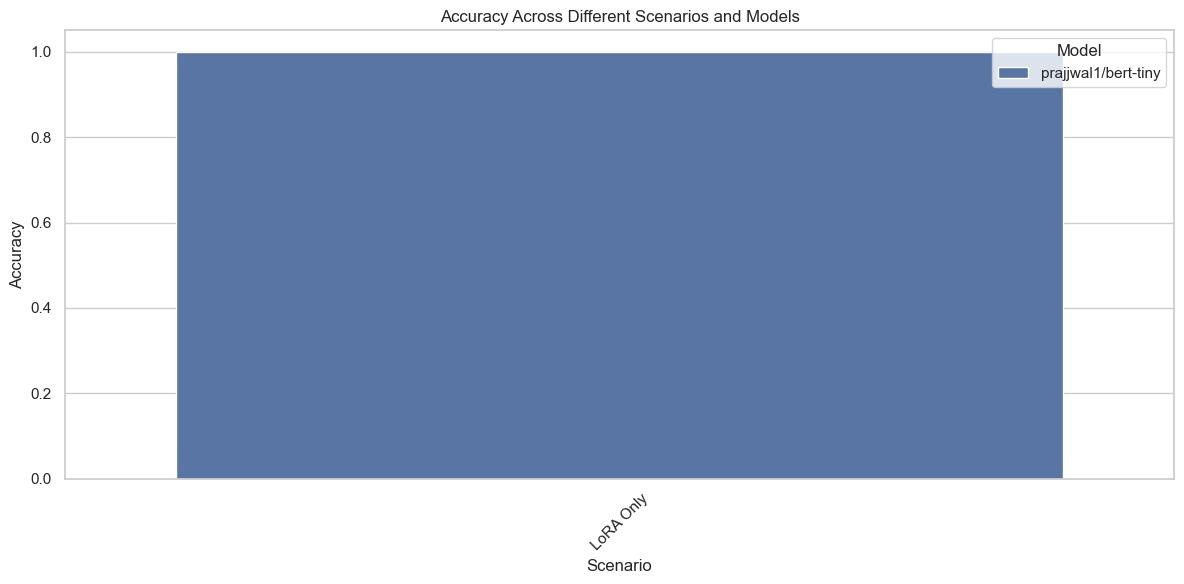

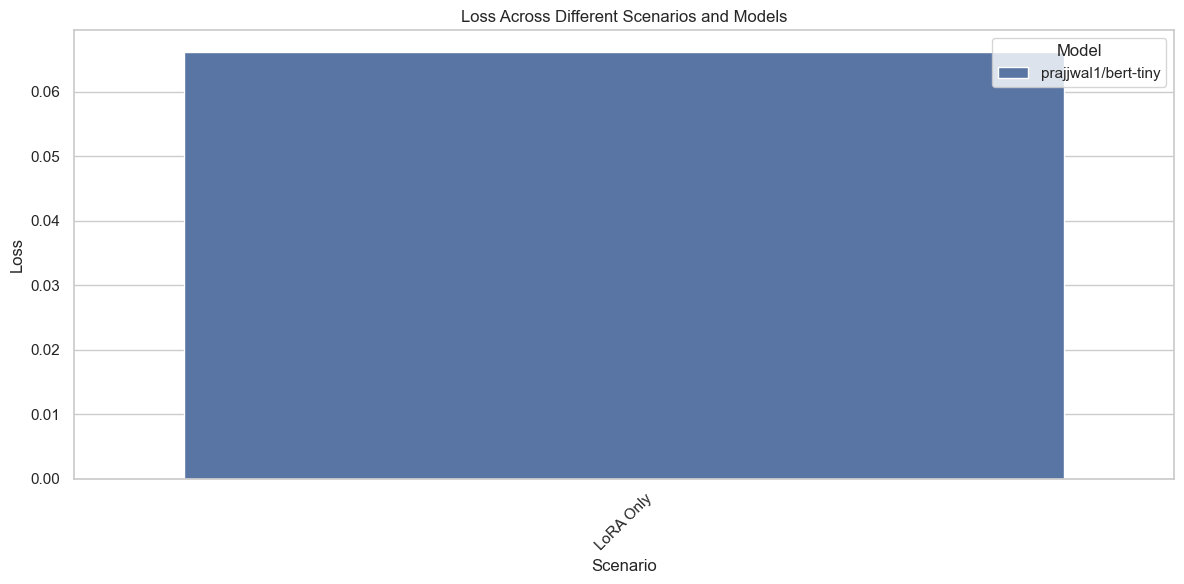

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Accuracy visualization
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Accuracy", hue="Model")
plt.title("Accuracy Across Different Scenarios and Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Loss visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Scenario", y="Loss", hue="Model")
plt.title("Loss Across Different Scenarios and Models")
plt.ylabel("Loss")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()